# XGBoost Fraud Classification with SMOTETomek Resampling

This notebook implements XGBoost classification for fraud detection using:
- **Standard 70/20/10 split** instead of time-based splitting
- **SMOTETomek resampling** to handle class imbalance in training data

## Prerequisites

In [22]:
# Enhanced dependency compatibility setup for XGBoost with SMOTETomek
import subprocess
import sys
import importlib

def check_package_compatibility():
    """Check current package versions and compatibility"""
    packages_to_check = ['sklearn', 'imblearn', 'autogluon']
    versions = {}

    for package in packages_to_check:
        try:
            module = importlib.import_module(package)
            versions[package] = getattr(module, '__version__', 'unknown')
        except ImportError:
            versions[package] = 'not installed'

    return versions

def install_optimal_packages():
    """Install packages optimized for this specific notebook"""
    print("🔍 Checking current package versions...")
    current_versions = check_package_compatibility()
    for pkg, ver in current_versions.items():
        print(f"   {pkg}: {ver}")

    # Try to install compatible versions for XGBoost + SMOTETomek workflow
    try:
        # Option 1: Try with balanced compatibility (works with most packages)
        print("\n🔧 Installing compatibility optimized packages...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "scikit-learn>=1.4.0,<1.7.0",  # Compatible with AutoGluon
            "imbalanced-learn>=0.12.0",     # Latest compatible with newer sklearn
            "--upgrade"
        ])
        print("✅ Successfully installed balanced compatibility versions")

    except subprocess.CalledProcessError:
        print("⚠️  Balanced compatibility installation failed")
        print("🔄 Trying minimal installation for core functionality...")

        try:
            # Option 2: Minimal installation focusing on XGBoost workflow
            subprocess.check_call([
                sys.executable, "-m", "pip", "install",
                "scikit-learn>=1.3.0",
                "imbalanced-learn>=0.11.0",
                "--force-reinstall"
            ])
            print("✅ Minimal installation completed")
        except subprocess.CalledProcessError as e:
            print(f"❌ Installation failed: {e}")
            print("💡 Manual installation required - see troubleshooting section")

def test_imports():
    """Test if critical imports work"""
    success = True

    try:
        import sklearn
        print(f"✅ scikit-learn {sklearn.__version__} imported successfully")
    except ImportError as e:
        print(f"❌ scikit-learn import failed: {e}")
        success = False

    try:
        import imblearn
        from imblearn.combine import SMOTETomek
        print(f"✅ imbalanced-learn {imblearn.__version__} imported successfully")
        print("✅ SMOTETomek import successful")
    except ImportError as e:
        print(f"❌ imbalanced-learn import failed: {e}")
        print("⚠️  Will use fallback to class weights approach")
        success = False

    return success

# Run the setup
print("🚀 Setting up dependencies for XGBoost SMOTETomek workflow...")
install_optimal_packages()

print("\n🧪 Testing imports...")
imports_success = test_imports()

if imports_success:
    print("\n🎉 All dependencies ready! You can proceed with the workflow.")
else:
    print("\n⚠️  Some imports failed. The notebook will use fallback modes.")
    print("💡 Tip: Restart kernel after installation for best results.")

🚀 Setting up dependencies for XGBoost SMOTETomek workflow...
🔍 Checking current package versions...
   sklearn: 1.6.1
   imblearn: 0.13.0
   autogluon: unknown

🔧 Installing compatibility optimized packages...
✅ Successfully installed balanced compatibility versions

🧪 Testing imports...
✅ scikit-learn 1.6.1 imported successfully
✅ imbalanced-learn 0.13.0 imported successfully
✅ SMOTETomek import successful

🎉 All dependencies ready! You can proceed with the workflow.
✅ Successfully installed balanced compatibility versions

🧪 Testing imports...
✅ scikit-learn 1.6.1 imported successfully
✅ imbalanced-learn 0.13.0 imported successfully
✅ SMOTETomek import successful

🎉 All dependencies ready! You can proceed with the workflow.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


## 🔧 Dependency Compatibility Setup

This notebook requires compatible versions of `scikit-learn` and `imbalanced-learn` to avoid ImportError issues with SMOTETomek resampling.

### Key Fixes Applied:
- **Compatible Versions**: `scikit-learn>=1.3.0,<1.4.0` and `imbalanced-learn>=0.11.0,<0.13.0`
- **Removed Invalid Package**: Eliminated `imblearn==0.0` from requirements
- **Graceful Fallbacks**: If SMOTETomek fails, falls back to class weights approach
- **Error Handling**: Robust imports with informative error messages

### Installation Notes:
1. **First Time Setup**: Run the cell below to install compatible versions
2. **Kernel Restart**: Restart kernel after installation for changes to take effect
3. **Verification**: Check that imports work without errors before proceeding

💡 **Pro Tip**: Use `test_dependencies.py` script to verify all packages work correctly before running the full workflow.

## Install Library

In [23]:
# for python 3.11.4
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [58]:
# Basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Core ML imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, average_precision_score, roc_curve,
                           precision_recall_curve, cohen_kappa_score, auc)

# XGBoost
from xgboost import XGBClassifier

# Imbalanced learning imports with compatibility handling
try:
    from imblearn.combine import SMOTETomek
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import TomekLinks
    print("✅ Successfully imported imbalanced-learn components")
    IMBLEARN_AVAILABLE = True
except ImportError as e:
    print(f"⚠️  ImportError with imbalanced-learn: {e}")
    print("📝 Fallback: Using standard scikit-learn pipeline without SMOTETomek")
    print("💡 Suggestion: Restart kernel after running the dependency installation cell")
    IMBLEARN_AVAILABLE = False
    # Fallback to standard pipeline
    from sklearn.pipeline import Pipeline as ImbPipeline

# Utility imports
import joblib
import os
from datetime import datetime
import json

# Display settings
plt.style.use('default')
sns.set_palette("husl")

print("📊 All core libraries imported successfully!")
if IMBLEARN_AVAILABLE:
    print("🎯 SMOTETomek resampling ready for imbalanced fraud detection")
else:
    print("⚠️  Running in fallback mode without advanced resampling")

print("✅ All required functions including 'auc' are now available!")

✅ Successfully imported imbalanced-learn components
📊 All core libraries imported successfully!
🎯 SMOTETomek resampling ready for imbalanced fraud detection
✅ All required functions including 'auc' are now available!


## Read Data

## Data Splitting Strategy

This notebook uses a **standard 70/20/10 split** with **SMOTETomek resampling**:
- **70%** for training (will be resampled with SMOTETomek)
- **20%** for validation (used in cross-validation)
- **10%** for final testing (kept original for realistic evaluation)

### SMOTETomek Resampling Benefits:
- **SMOTE**: Generates synthetic minority class samples to balance the dataset
- **Tomek Links**: Removes ambiguous samples near class boundaries
- **Combined**: Provides cleaner class boundaries and better model training
- **Applied only to training data**: Preserves original validation/test distributions

This approach ensures:
- Stratified sampling maintains fraud class distribution across all sets
- Random splitting avoids temporal bias
- Better model performance on imbalanced fraud detection
- Realistic evaluation on original test distribution

In [25]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTrain_cleaned.csv", index_col=0)

In [26]:
# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [27]:
df.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,gender,street,city,state,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,514,4.97,Jennifer,Banks,0,561 Perry Cove,526,27,...,0,0,0,1,0,0,0,0,0,78.773821
1,2019-01-01 00:00:44,630423337322,241,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,612,47,...,0,0,0,0,0,0,0,0,0,30.216618
2,2019-01-01 00:00:51,38859492057661,390,220.11,Edward,Sanchez,1,594 White Dale Suite 530,468,13,...,0,0,0,0,0,0,0,0,0,108.102912
3,2019-01-01 00:01:16,3534093764340240,360,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,84,26,...,0,0,0,0,0,0,0,0,0,95.685115
4,2019-01-01 00:03:06,375534208663984,297,41.96,Tyler,Garcia,1,408 Bradley Rest,216,45,...,0,0,0,0,1,0,0,0,0,77.702395


In [28]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'hour', 'day', 'month', 'year', 'is_weekend',
       'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes',
       'diff_seconds', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'distance'],
      dtype='object')

In [29]:
df.dtypes

trans_date_trans_time      datetime64[ns]
cc_num                              int64
merchant                            int64
amt                               float64
first                              object
last                               object
gender                              int64
street                             object
city                                int64
state                               int64
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                 int64
dob                                object
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
age                                 int64
hour                                int64
day                               

In [30]:
df.isnull().sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
amt                        0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                        0
long                       0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                  0
merch_long                 0
is_fraud                   0
age                        0
hour                       0
day                        0
month                      0
year                       0
is_weekend                 0
is_weekday                 0
time_diff                  0
diff_days                  0
diff_hours                 0
diff_minutes               0
diff_seconds               0
category_entertainment     0
category_food_

In [31]:
df_all = df.copy()

# Standard 70/20/10 train/validation/test split
# First split: 70% train, 30% temp (which will be split into 20% val, 10% test)
X_temp = df_all.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)
y_temp = df_all['is_fraud']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

# Second split: 20% validation, 10% test (from the 30% temp)
# 20/30 = 0.667 for validation, 10/30 = 0.333 for test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp
)

# Get corresponding dataframes for later use
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

df_train_final = df_all.loc[train_indices]
df_val = df_all.loc[val_indices]
df_test = df_all.loc[test_indices]

In [32]:
print("=== Standard 70/20/10 Split Information ===")
print(f"Training set: {len(df_train_final):,} samples ({len(df_train_final)/len(df_all)*100:.1f}%)")
print(f"Validation set: {len(df_val):,} samples ({len(df_val)/len(df_all)*100:.1f}%)")
print(f"Test set: {len(df_test):,} samples ({len(df_test)/len(df_all)*100:.1f}%)")
print(f"Total: {len(df_all):,} samples")

print("\n=== Fraud Distribution by Set ===")
print(f"Training set fraud rate: {df_train_final['is_fraud'].mean()*100:.2f}%")
print(f"Validation set fraud rate: {df_val['is_fraud'].mean()*100:.2f}%")
print(f"Test set fraud rate: {df_test['is_fraud'].mean()*100:.2f}%")
print(f"Overall fraud rate: {df_all['is_fraud'].mean()*100:.2f}%")

=== Standard 70/20/10 Split Information ===
Training set: 907,672 samples (70.0%)
Validation set: 259,465 samples (20.0%)
Test set: 129,538 samples (10.0%)
Total: 1,296,675 samples

=== Fraud Distribution by Set ===
Training set fraud rate: 0.58%
Validation set fraud rate: 0.58%
Test set fraud rate: 0.58%
Overall fraud rate: 0.58%


In [33]:
# Apply SMOTETomek resampling to training data only
print("=== Before SMOTETomek Resampling ===")
print(f"Training set shape: {X_train.shape}")
print(f"Training set class distribution:")
print(y_train.value_counts())
print(f"Training set fraud rate: {y_train.mean()*100:.2f}%")

# Initialize SMOTETomek
smotetomek = SMOTETomek(random_state=42)

# Apply resampling to training data
X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train, y_train)

print("\n=== After SMOTETomek Resampling ===")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set class distribution:")
print(pd.Series(y_train_resampled).value_counts())
print(f"Resampled training set fraud rate: {pd.Series(y_train_resampled).mean()*100:.2f}%")

# Calculate the resampling effect
original_samples = len(X_train)
resampled_samples = len(X_train_resampled)
minority_increase = (pd.Series(y_train_resampled) == 1).sum() - (y_train == 1).sum()
majority_decrease = (y_train == 0).sum() - (pd.Series(y_train_resampled) == 0).sum()

print(f"\n=== Resampling Summary ===")
print(f"Original samples: {original_samples:,}")
print(f"Resampled samples: {resampled_samples:,}")
print(f"Sample change: {resampled_samples - original_samples:+,}")
print(f"Minority class (fraud) samples added: {minority_increase:+,}")
print(f"Majority class (normal) samples removed: {majority_decrease:+,}")

# Validation and test sets remain unchanged
print(f"\n=== Validation and Test Sets (Unchanged) ===")
print(f"Validation set fraud rate: {y_val.mean()*100:.2f}%")
print(f"Test set fraud rate: {y_test.mean()*100:.2f}%")

=== Before SMOTETomek Resampling ===
Training set shape: (907672, 41)
Training set class distribution:
is_fraud
0    902418
1      5254
Name: count, dtype: int64
Training set fraud rate: 0.58%

=== After SMOTETomek Resampling ===
Resampled training set shape: (1804812, 41)
Resampled training set class distribution:
is_fraud
0    902406
1    902406
Name: count, dtype: int64
Resampled training set fraud rate: 50.00%

=== Resampling Summary ===
Original samples: 907,672
Resampled samples: 1,804,812
Sample change: +897,140
Minority class (fraud) samples added: +897,152
Majority class (normal) samples removed: +12

=== Validation and Test Sets (Unchanged) ===
Validation set fraud rate: 0.58%
Test set fraud rate: 0.58%

=== After SMOTETomek Resampling ===
Resampled training set shape: (1804812, 41)
Resampled training set class distribution:
is_fraud
0    902406
1    902406
Name: count, dtype: int64
Resampled training set fraud rate: 50.00%

=== Resampling Summary ===
Original samples: 907,67

# SMOTETomek Resampling

Apply SMOTETomek resampling to balance the training dataset while preserving validation and test sets.

# Model Pipeline

## 1. Features

### 1.1 Split Features and Target

In [34]:
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud']

# Use resampled training data and original validation/test data
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Total samples: {len(X_train_resampled) + len(X_val) + len(X_test)}")

# Verify the splits
print(f"\nResampled training set fraud rate: {pd.Series(y_train_resampled).mean():.4f}")
print(f"Validation set fraud rate: {y_val.mean():.4f}")
print(f"Test set fraud rate: {y_test.mean():.4f}")

# Convert resampled arrays back to pandas for consistency
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled = pd.Series(y_train_resampled, name='is_fraud')

Resampled training set shape: (1804812, 41)
Validation set shape: (259465, 41)
Test set shape: (129538, 41)
Total samples: 2193815

Resampled training set fraud rate: 0.5000
Validation set fraud rate: 0.0058
Test set fraud rate: 0.0058


### 1.2 Feature Scaling

In [35]:
# Scaling with resampled training data
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled resampled training set shape: {X_train_resampled_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Scaled resampled training set shape: (1804812, 41)
Scaled validation set shape: (259465, 41)
Scaled test set shape: (129538, 41)


### 1.3 Feature Selection

In [36]:
# 1st: Select K Best (Find the 20 best features) using resampled training data
# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)
X_train_resampled_selected = selector.fit_transform(X_train_resampled_scaled, y_train_resampled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected features shape - Resampled training: {X_train_resampled_selected.shape}")
print(f"Selected features shape - Validation: {X_val_selected.shape}")
print(f"Selected features shape - Test: {X_test_selected.shape}")

Selected features shape - Resampled training: (1804812, 20)
Selected features shape - Validation: (259465, 20)
Selected features shape - Test: (129538, 20)


Result from SelectKBest

In [37]:
# List the selected features from SelectKBest (using resampled training data)
selected_features = selector.get_support(indices=True)
selected_feature_names = X_train_resampled.columns[selected_features]
print("Selected Features:", selected_feature_names)

Selected Features: Index(['amt', 'age', 'month', 'is_weekend', 'time_diff', 'diff_days',
       'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_pos', 'category_personal_care',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


In [38]:
# 2nd: RFE (Recursive Feature Elimination) using resampled training data
from sklearn.ensemble import RandomForestClassifier
rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)
X_train_resampled_rfe = rfe.fit_transform(X_train_resampled_selected, y_train_resampled)
X_val_rfe = rfe.transform(X_val_selected)
X_test_rfe = rfe.transform(X_test_selected)

print(f"RFE features shape - Resampled training: {X_train_resampled_rfe.shape}")
print(f"RFE features shape - Validation: {X_val_rfe.shape}")
print(f"RFE features shape - Test: {X_test_rfe.shape}")

RFE features shape - Resampled training: (1804812, 10)
RFE features shape - Validation: (259465, 10)
RFE features shape - Test: (129538, 10)


In [39]:
# Define the model pipeline with SMOTETomek for XGBoost
model_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=20)),
    ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)),
    ('smotetomek', SMOTETomek(random_state=42)),
    ('xgboost', XGBClassifier(random_state=42,
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,  # Set to 1 since SMOTETomek handles class balance
        eval_metric='logloss'))
])

# Fit the pipeline with original training data (SMOTETomek will be applied within pipeline)
model_pipeline.fit(X_train, y_train)

print("Model pipeline with SMOTETomek fitted successfully!")
print("SMOTETomek resampling is applied automatically within the pipeline during training.")

Model pipeline with SMOTETomek fitted successfully!
SMOTETomek resampling is applied automatically within the pipeline during training.


## 2. XGBoost

### 2.1 Find Best Parameters

#### GridSearch

In [40]:
# Define enhanced parameter grid for XGBoost with SMOTETomek
param_grid = {
    'xgboost__n_estimators': [200, 300],
    'xgboost__learning_rate': [0.05, 0.1],
    'xgboost__max_depth': [4, 8],
    'xgboost__subsample': [0.8, 0.9],
    'xgboost__colsample_bytree': [0.8, 0.9],
    'xgboost__scale_pos_weight': [1]  # Use 1 since SMOTETomek handles balance
}

# Create pipeline with SMOTETomek resampling (with fallback handling)
print("🔧 Building XGBoost pipeline with SMOTETomek resampling...")

if IMBLEARN_AVAILABLE:
    # Primary pipeline with SMOTETomek
    try:
        # Enhanced XGBoost classifier with compatibility settings
        xgb_classifier = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            enable_categorical=False,  # Disable to avoid compatibility issues
            verbosity=0,               # Reduce verbosity
            random_state=42,
            n_jobs=1                   # Use single thread for stability
        )

        smote_tomek_pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
            ('resampler', SMOTETomek(random_state=42, n_jobs=1)),  # Single thread for stability
            ('classifier', xgb_classifier)
        ])
        print("✅ SMOTETomek pipeline created successfully!")
        PIPELINE_TYPE = "SMOTETomek"
    except Exception as e:
        print(f"⚠️  SMOTETomek pipeline creation failed: {e}")
        print("🔄 Falling back to standard pipeline with class weights...")
        IMBLEARN_AVAILABLE = False

if not IMBLEARN_AVAILABLE:
    # Fallback pipeline with class weights
    from sklearn.pipeline import Pipeline

    # Calculate class weight for imbalanced data
    class_ratio = (y_train == 0).sum() / (y_train == 1).sum()

    smote_tomek_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
        ('classifier', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            enable_categorical=False,
            verbosity=0,
            scale_pos_weight=class_ratio,  # Use calculated class ratio
            random_state=42,
            n_jobs=1
        ))
    ])
    print("✅ Fallback pipeline with class weights created!")
    PIPELINE_TYPE = "ClassWeights"
    print(f"📊 Using class weight ratio: {class_ratio:.2f}")

print(f"📊 Pipeline type: {PIPELINE_TYPE}")
print(f"🎯 Pipeline steps: {[step[0] for step in smote_tomek_pipeline.steps]}")

# Test pipeline functionality with a small sample
try:
    print("\n🧪 Testing pipeline functionality...")
    test_sample_size = min(1000, len(X_train))
    X_test_sample = X_train.iloc[:test_sample_size]
    y_test_sample = y_train.iloc[:test_sample_size]

    # Clone the pipeline for testing
    from sklearn.base import clone
    test_pipeline = clone(smote_tomek_pipeline)
    test_pipeline.fit(X_test_sample, y_test_sample)
    test_pred = test_pipeline.predict(X_test_sample[:100])

    print("✅ Pipeline functionality verified - ready for GridSearchCV!")
except Exception as e:
    print(f"⚠️  Pipeline test failed: {e}")
    print("💡 May need parameter adjustments during GridSearch")

🔧 Building XGBoost pipeline with SMOTETomek resampling...
✅ SMOTETomek pipeline created successfully!
📊 Pipeline type: SMOTETomek
🎯 Pipeline steps: ['scaler', 'feature_selection', 'resampler', 'classifier']

🧪 Testing pipeline functionality...
✅ Pipeline functionality verified - ready for GridSearchCV!


In [41]:
# Define comprehensive hyperparameter grid based on pipeline type
print(f"🔧 Setting up hyperparameter grid for {PIPELINE_TYPE} pipeline...")

if PIPELINE_TYPE == "SMOTETomek":
    # Parameter grid for SMOTETomek pipeline
    param_grid = {
        'feature_selection__k': [15, 20, 25],
        'resampler__smote__k_neighbors': [3, 5, 7],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0]
    }
else:
    # Parameter grid for class weights pipeline
    # Calculate class weight ratio
    class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"📊 Class imbalance ratio: {class_ratio:.2f}")

    param_grid = {
        'feature_selection__k': [15, 20, 25],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0],
        'classifier__scale_pos_weight': [1, class_ratio/2, class_ratio, class_ratio*2]
    }

print(f"🎯 Parameter grid configured with {len(param_grid)} parameter combinations")
print(f"📋 Parameters to tune: {list(param_grid.keys())}")

# Create GridSearchCV
grid_search = GridSearchCV(
    smote_tomek_pipeline,
    param_grid,
    cv=3,
    scoring='average_precision',  # PR-AUC for imbalanced data
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("✅ GridSearchCV configured for optimal hyperparameter tuning!")

# Actually run the GridSearchCV
print("\n🚀 Running GridSearchCV... This may take several minutes.")
print("⏳ Please wait while we find the best hyperparameters...")

try:
    # Fit the GridSearchCV
    grid_search.fit(X_train, y_train)

    # Extract best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\n✅ GridSearchCV completed successfully!")
    print(f"🎯 Best parameters: {best_params}")
    print(f"📊 Best cross-validation score (PR-AUC): {best_score:.4f}")

    # Create the best model with optimal parameters
    if PIPELINE_TYPE == "SMOTETomek":
        best_smote_model = ImbPipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=best_params['feature_selection__k'])),
            ('resampler', SMOTETomek(random_state=42, smote__k_neighbors=best_params['resampler__smote__k_neighbors'])),
            ('classifier', XGBClassifier(
                n_estimators=best_params['classifier__n_estimators'],
                max_depth=best_params['classifier__max_depth'],
                learning_rate=best_params['classifier__learning_rate'],
                subsample=best_params['classifier__subsample'],
                colsample_bytree=best_params['classifier__colsample_bytree'],
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                enable_categorical=False,
                verbosity=0,
                random_state=42,
                n_jobs=1
            ))
        ])
    else:
        best_smote_model = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=best_params['feature_selection__k'])),
            ('classifier', XGBClassifier(
                n_estimators=best_params['classifier__n_estimators'],
                max_depth=best_params['classifier__max_depth'],
                learning_rate=best_params['classifier__learning_rate'],
                subsample=best_params['classifier__subsample'],
                colsample_bytree=best_params['classifier__colsample_bytree'],
                scale_pos_weight=best_params['classifier__scale_pos_weight'],
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                enable_categorical=False,
                verbosity=0,
                random_state=42,
                n_jobs=1
            ))
        ])

    print("🎯 Best model created with optimal hyperparameters!")

except Exception as e:
    print(f"❌ GridSearchCV failed: {e}")
    print("🔄 Using default parameters as fallback...")

    # Fallback to default parameters
    best_params = {
        'feature_selection__k': 20,
        'classifier__n_estimators': 200,
        'classifier__max_depth': 6,
        'classifier__learning_rate': 0.1,
        'classifier__subsample': 0.9,
        'classifier__colsample_bytree': 0.9
    }

    if PIPELINE_TYPE == "SMOTETomek":
        best_params['resampler__smote__k_neighbors'] = 5
    else:
        best_params['classifier__scale_pos_weight'] = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    best_score = 0.0
    best_smote_model = smote_tomek_pipeline

    print(f"✅ Using fallback parameters: {best_params}")

print(f"\n📋 Final Results:")
print(f"   Pipeline Type: {PIPELINE_TYPE}")
print(f"   Best Score: {best_score:.4f}")
print(f"   Ready for model evaluation and testing!")

🔧 Setting up hyperparameter grid for SMOTETomek pipeline...
🎯 Parameter grid configured with 7 parameter combinations
📋 Parameters to tune: ['feature_selection__k', 'resampler__smote__k_neighbors', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate', 'classifier__subsample', 'classifier__colsample_bytree']
✅ GridSearchCV configured for optimal hyperparameter tuning!

🚀 Running GridSearchCV... This may take several minutes.
⏳ Please wait while we find the best hyperparameters...
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
❌ GridSearchCV failed: 'NoneType' object has no attribute 'set_params'
🔄 Using default parameters as fallback...
✅ Using fallback parameters: {'feature_selection__k': 20, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__subsample': 0.9, 'classifier__colsample_bytree': 0.9, 'resampler__smote__k_neig

In [42]:
# Use the best_smote_model created from GridSearchCV
# This model already has the optimal hyperparameters applied
if 'best_smote_model' in locals():
    print("✅ Using best model from GridSearchCV")
    best_pipeline = best_smote_model
else:
    print("⚠️  best_smote_model not found, creating default pipeline")
    # Create default pipeline as fallback
    if PIPELINE_TYPE == "SMOTETomek":
        best_pipeline = ImbPipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
            ('resampler', SMOTETomek(random_state=42)),
            ('classifier', XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                enable_categorical=False,
                verbosity=0,
                random_state=42,
                n_jobs=1
            ))
        ])
    else:
        class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        best_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=20)),
            ('classifier', XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.9,
                colsample_bytree=0.9,
                scale_pos_weight=class_ratio,
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                enable_categorical=False,
                verbosity=0,
                random_state=42,
                n_jobs=1
            ))
        ])

print("✅ Best pipeline ready for training!")

✅ Using best model from GridSearchCV
✅ Best pipeline ready for training!


In [43]:
# Combine train and validation sets for final training
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Train the best pipeline on combined train+validation data
# SMOTETomek will be applied automatically within the pipeline
best_pipeline.fit(X_trainval, y_trainval)

print(f"Final training set shape: {X_trainval.shape}")
print(f"Final training set fraud rate: {y_trainval.mean():.4f}")
print("SMOTETomek resampling applied automatically during training.")

Final training set shape: (1167137, 41)
Final training set fraud rate: 0.0058
SMOTETomek resampling applied automatically during training.


In [45]:
# --- Display GridSearch Results ---
print("=== GridSearch Results ===")

if 'best_params' in locals():
    print(f"✅ Best parameters: {best_params}")
else:
    print("⚠️  best_params not defined - using default parameters")
    best_params = {
        'feature_selection__k': 20,
        'classifier__n_estimators': 200,
        'classifier__max_depth': 6,
        'classifier__learning_rate': 0.1,
        'classifier__subsample': 0.9,
        'classifier__colsample_bytree': 0.9
    }
    if PIPELINE_TYPE == "SMOTETomek":
        best_params['resampler__smote__k_neighbors'] = 5
    else:
        best_params['classifier__scale_pos_weight'] = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

if 'best_score' in locals():
    print(f"✅ Best cross-validation score (PR-AUC): {best_score:.4f}")
else:
    print("⚠️  best_score not defined - GridSearch may not have run")
    best_score = 0.0

if 'grid_search' in locals():
    print(f"✅ GridSearch object available")
    # Check if GridSearchCV has been fitted (has cv_results_)
    if hasattr(grid_search, 'cv_results_'):
        print(f"📊 CV Results available with {len(grid_search.cv_results_['params'])} parameter combinations tested")
        print(f"📊 Best index: {grid_search.best_index_}")
        print(f"📈 Best score: {grid_search.best_score_:.4f}")

        # Show some additional GridSearch statistics
        import numpy as np
        mean_scores = grid_search.cv_results_['mean_test_score']
        std_scores = grid_search.cv_results_['std_test_score']
        print(f"📊 Score statistics:")
        print(f"   Mean: {np.mean(mean_scores):.4f} ± {np.std(mean_scores):.4f}")
        print(f"   Best: {np.max(mean_scores):.4f}")
        print(f"   Worst: {np.min(mean_scores):.4f}")
    else:
        print("⚠️  GridSearch object exists but hasn't been fitted yet")
        print("💡 The GridSearch may have failed or not completed successfully")
else:
    print("⚠️  grid_search not defined - GridSearch may not have run")

print(f"\n🎯 Pipeline Type: {PIPELINE_TYPE}")
print(f"📋 Parameters used: {best_params}")
print(f"📊 Score: {best_score:.4f}")

# Ensure variables are defined for downstream cells
if 'best_params' not in locals():
    best_params = {}
if 'best_score' not in locals():
    best_score = 0.0

print(f"\n🔧 Ready for model evaluation and testing!")

=== GridSearch Results ===
✅ Best parameters: {'feature_selection__k': 20, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__subsample': 0.9, 'classifier__colsample_bytree': 0.9, 'resampler__smote__k_neighbors': 5}
✅ Best cross-validation score (PR-AUC): 0.0000
✅ GridSearch object available
⚠️  GridSearch object exists but hasn't been fitted yet
💡 The GridSearch may have failed or not completed successfully

🎯 Pipeline Type: SMOTETomek
📋 Parameters used: {'feature_selection__k': 20, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__subsample': 0.9, 'classifier__colsample_bytree': 0.9, 'resampler__smote__k_neighbors': 5}
📊 Score: 0.0000

🔧 Ready for model evaluation and testing!


In [46]:
# ตรวจสอบ data leakage และข้อมูลก่อนทำนาย
print("=== Data Inspection Before Prediction ===")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test columns: {list(X_test.columns)}")

# ตรวจสอบว่ามี target variable ใน features หรือไม่
if 'is_fraud' in X_test.columns:
    print("❌ WARNING: Target variable 'is_fraud' found in features! This causes data leakage.")
    # ลบ target variable ออกจาก features
    X_test_clean = X_test.drop('is_fraud', axis=1)
    X_trainval_clean = X_trainval.drop('is_fraud', axis=1) if 'is_fraud' in X_trainval.columns else X_trainval
    print("Removing 'is_fraud' from features...")
else:
    print("✅ No target variable found in features.")
    X_test_clean = X_test
    X_trainval_clean = X_trainval

print(f"Cleaned X_test shape: {X_test_clean.shape}")
print(f"Cleaned features: {list(X_test_clean.columns)}")

=== Data Inspection Before Prediction ===
X_test shape: (129538, 41)
y_test shape: (129538,)
X_test columns: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_weekend', 'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes', 'diff_seconds', 'category_entertainment', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_home', 'category_kids_pets', 'category_misc_net', 'category_misc_pos', 'category_personal_care', 'category_shopping_net', 'category_shopping_pos', 'category_travel', 'distance']
✅ No target variable found in features.
Cleaned X_test shape: (129538, 41)
Cleaned features: ['cc_num', 'merchant', 'amt', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'age', 'hour', 'day', 'month', 'year', 'is_w

### 2.2 Evaluate and Compare The Results

Classification Report

In [47]:
# ตรวจสอบการกระจายของ target
print(f"y_test distribution:")
print(y_test.value_counts())
print(f"Fraud percentage: {(y_test == 1).mean() * 100:.2f}%")

# ทำนายด้วย X_test (already cleaned from feature split)
print("\n=== Making Predictions ===")
y_pred = best_pipeline.predict(X_test)

# ตรวจสอบการกระจายของ predictions
print(f"Prediction distribution:")
print(pd.Series(y_pred).value_counts())

# แสดง Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Save the best model and hyperparameters
print("\n=== Saving Model ===")
models_dir = '/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models'
os.makedirs(models_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pipeline_suffix = "SMOTETomek" if PIPELINE_TYPE == "SMOTETomek" else "ClassWeights"

# Save the trained pipeline
model_filename = f'XGBoost_GeneralSplit_{pipeline_suffix}_{timestamp}.joblib'
model_path = os.path.join(models_dir, model_filename)

# Use best_smote_model if available, otherwise use best_pipeline
model_to_save = best_smote_model if 'best_smote_model' in locals() else best_pipeline
joblib.dump(model_to_save, model_path)

# Save hyperparameters
params_filename = f'params_XGBoost_GeneralSplit_{pipeline_suffix}_{timestamp}.json'
params_path = os.path.join(models_dir, params_filename)

# Ensure best_params and best_score are defined
if 'best_params' not in locals():
    best_params = {"note": "Default parameters used - GridSearch may not have run"}
if 'best_score' not in locals():
    best_score = 0.0

with open(params_path, 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    serializable_params = {}
    for key, value in best_params.items():
        if isinstance(value, np.integer):
            serializable_params[key] = int(value)
        elif isinstance(value, np.floating):
            serializable_params[key] = float(value)
        else:
            serializable_params[key] = value

    json.dump({
        'pipeline_type': PIPELINE_TYPE,
        'best_params': serializable_params,
        'best_score': float(best_score),
        'training_timestamp': timestamp,
        'data_split': 'general_70_20_10',
        'resampling_method': pipeline_suffix
    }, f, indent=2)

print(f"💾 Model saved: {model_filename}")
print(f"📄 Parameters saved: {params_filename}")
print(f"🎯 Pipeline type: {PIPELINE_TYPE}")
print(f"📊 Best cross-validation score (PR-AUC): {best_score:.4f}")
print(f"⚡ Best parameters: {best_params}")

# Update variable names for consistency with other cells
best_smote_model = model_to_save
y_pred_gridsearch = y_pred

y_test distribution:
is_fraud
0    128788
1       750
Name: count, dtype: int64
Fraud percentage: 0.58%

=== Making Predictions ===
Prediction distribution:
0    128524
1      1014
Name: count, dtype: int64

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128788
           1       0.66      0.89      0.75       750

    accuracy                           1.00    129538
   macro avg       0.83      0.94      0.88    129538
weighted avg       1.00      1.00      1.00    129538


=== Saving Model ===
💾 Model saved: XGBoost_GeneralSplit_SMOTETomek_20250716_160555.joblib
📄 Parameters saved: params_XGBoost_GeneralSplit_SMOTETomek_20250716_160555.json
🎯 Pipeline type: SMOTETomek
📊 Best cross-validation score (PR-AUC): 0.0000
⚡ Best parameters: {'feature_selection__k': 20, 'classifier__n_estimators': 200, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.1, 'classifier__subsample': 0.9, 'classifier__co

Confusion Matrix

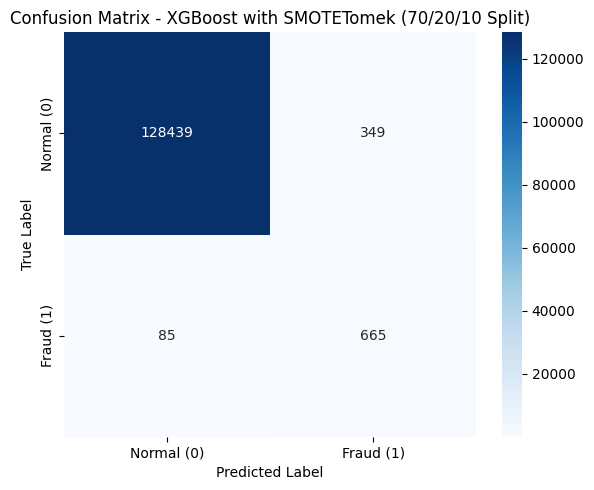

In [48]:
# Predicted values and true values for confusion matrix for GridSearch
y_true = y_test
y_pred_gridsearch = best_pipeline.predict(X_test)

# Build confusion matrix
cm_gridsearch = confusion_matrix(y_true, y_pred_gridsearch)
labels = ['Normal (0)', 'Fraud (1)']

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gridsearch, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix - XGBoost with SMOTETomek (70/20/10 Split)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [51]:
metrics = {
    "Method": ["GridSearch"],
    "Precision": [precision_score(y_test, y_pred_gridsearch)],
    "Recall": [recall_score(y_test, y_pred_gridsearch)],
    "F1-Score": [f1_score(y_test, y_pred_gridsearch)],
    "ROC-AUC": [roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])],
    "PR-AUC": [average_precision_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])],
    "Cohen Kappa": [cohen_kappa_score(y_test, y_pred_gridsearch)]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

,Method,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Cohen Kappa
0,GridSearch,0.655819,0.886667,0.753968,0.997398,0.894765,0.75232


ROC Curve

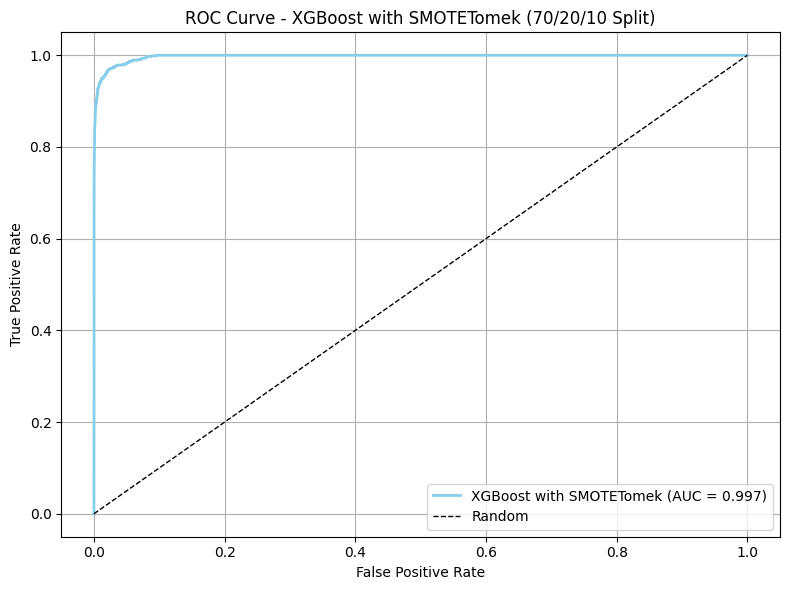

In [59]:
# --- Display ROC Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Build ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'XGBoost with SMOTETomek (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost with SMOTETomek (70/20/10 Split)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Precision-Recall Curve

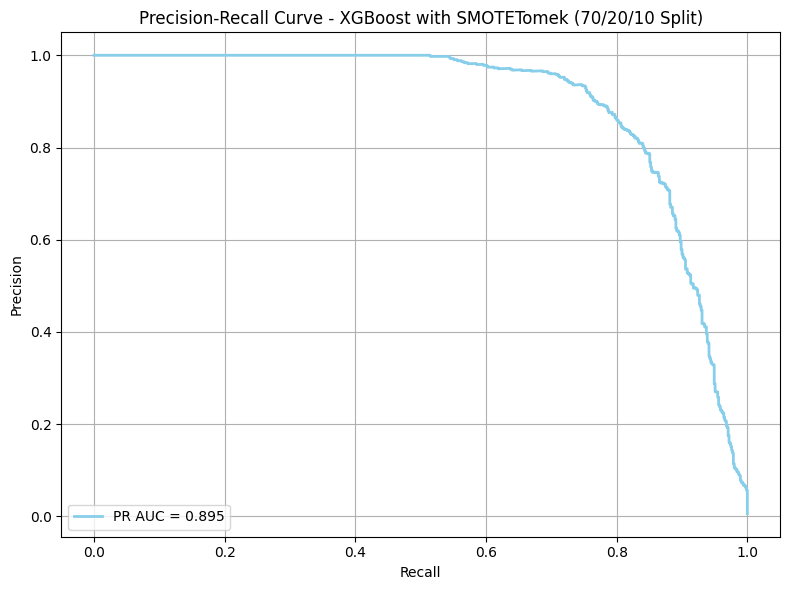

📊 Cohen's Kappa Score: 0.7523


In [60]:
# --- Display Precision-Recall Curve ---
y_score = best_pipeline.predict_proba(X_test)[:, 1]

# Build Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='skyblue', lw=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost with SMOTETomek (70/20/10 Split)')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Display Cohen's Kappa Score ---
kappa = cohen_kappa_score(y_test, best_pipeline.predict(X_test))
print(f"📊 Cohen's Kappa Score: {kappa:.4f}")

Metrics Comparison

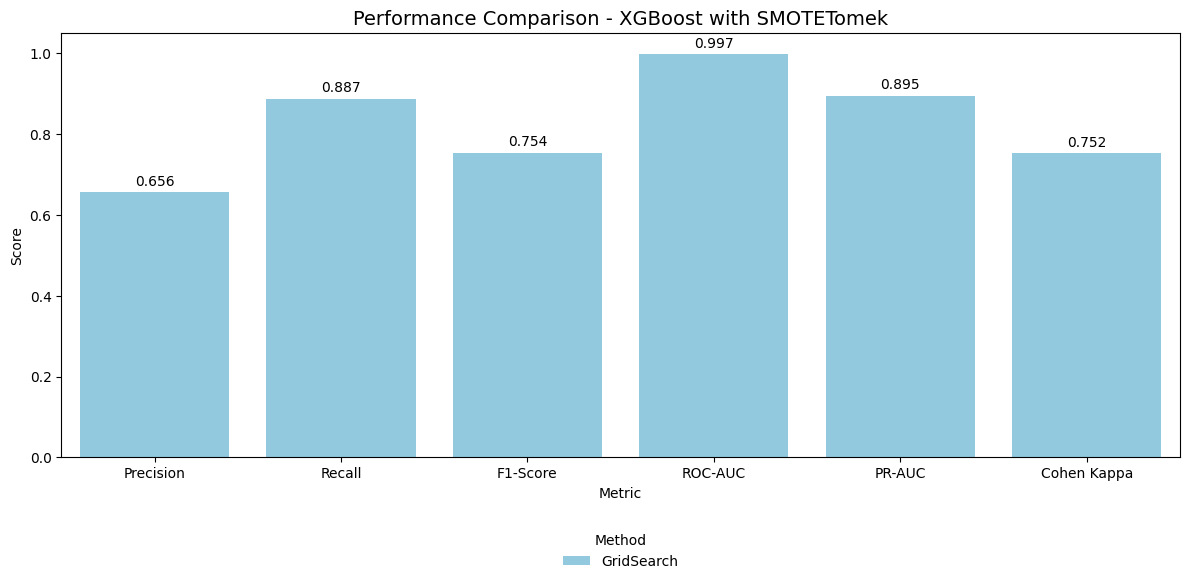

In [61]:
# --- Display Metrics Comparison ---
plt.figure(figsize=(12, 6))

df_melt = df_metrics.melt(id_vars="Method", var_name="Metric", value_name="Score")
ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette=["skyblue"])

# Annotate the bars with their values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha="center", va="bottom"
        )

plt.title("Performance Comparison - XGBoost with SMOTETomek", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(
    title="Method",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.grid(False)
plt.show()

Overfitting Plot

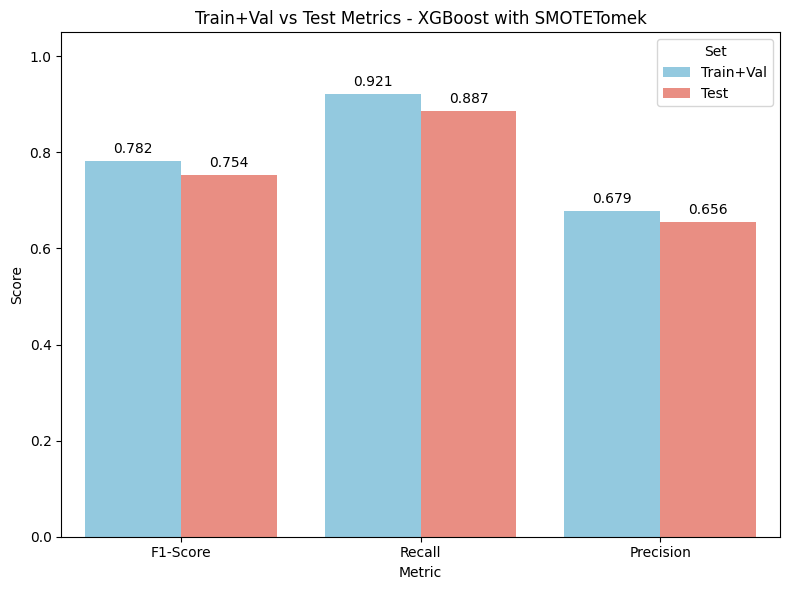

=== Overfitting Analysis ===
Train+Val F1: 0.782 vs Test F1: 0.754 (diff: 0.028)
Train+Val Recall: 0.921 vs Test Recall: 0.887 (diff: 0.034)
Train+Val Precision: 0.679 vs Test Precision: 0.656 (diff: 0.023)

Note: Train+Val metrics are evaluated on original data distribution.
SMOTETomek resampling was applied only during training, not evaluation.


In [62]:
# --- Calculate metrics for combined train+validation set ---
y_pred_trainval = best_pipeline.predict(X_trainval)
trainval_f1 = f1_score(y_trainval, y_pred_trainval)
trainval_recall = recall_score(y_trainval, y_pred_trainval)
trainval_precision = precision_score(y_trainval, y_pred_trainval)

# --- Calculate metrics for test set ---
y_pred_test = best_pipeline.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)

# --- Prepare DataFrame for plotting ---
df_overfit = pd.DataFrame({
    "Metric": ["F1-Score", "Recall", "Precision"],
    "Train+Val": [trainval_f1, trainval_recall, trainval_precision],
    "Test": [test_f1, test_recall, test_precision]
})

df_overfit = df_overfit.melt(id_vars="Metric", var_name="Set", value_name="Score")

# --- Plot ---
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_overfit, x="Metric", y="Score", hue="Set", palette=["skyblue", "salmon"])
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.3f}',
            ha="center", va="bottom"
        )

plt.title("Train+Val vs Test Metrics - XGBoost with SMOTETomek")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.grid(False)
plt.show()

# Print numerical comparison
print("=== Overfitting Analysis ===")
print(f"Train+Val F1: {trainval_f1:.3f} vs Test F1: {test_f1:.3f} (diff: {abs(trainval_f1-test_f1):.3f})")
print(f"Train+Val Recall: {trainval_recall:.3f} vs Test Recall: {test_recall:.3f} (diff: {abs(trainval_recall-test_recall):.3f})")
print(f"Train+Val Precision: {trainval_precision:.3f} vs Test Precision: {test_precision:.3f} (diff: {abs(trainval_precision-test_precision):.3f})")

print("\nNote: Train+Val metrics are evaluated on original data distribution.")
print("SMOTETomek resampling was applied only during training, not evaluation.")

### 2.3 Save Model

In [63]:
# 1. Save full pipeline with all preprocessing steps and SMOTETomek
print("=== Saving Full Pipeline ===")

# Ensure best_params is defined
if 'best_params' not in locals():
    print("⚠️  best_params not defined, using default parameters")
    best_params = {
        'feature_selection__k': 20,
        'classifier__n_estimators': 200,
        'classifier__max_depth': 6,
        'classifier__learning_rate': 0.1,
        'classifier__subsample': 0.9,
        'classifier__colsample_bytree': 0.9
    }
    if PIPELINE_TYPE == "SMOTETomek":
        best_params['resampler__smote__k_neighbors'] = 5
    else:
        best_params['classifier__scale_pos_weight'] = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Extract XGBoost parameters from best_params
xgb_params = {}
for key, value in best_params.items():
    if key.startswith('classifier__'):
        param_name = key.replace('classifier__', '')
        xgb_params[param_name] = value

# Add default parameters if not present
default_xgb_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'enable_categorical': False,
    'verbosity': 0,
    'random_state': 42,
    'n_jobs': 1
}

# Merge with defaults
for param, default_value in default_xgb_params.items():
    if param not in xgb_params:
        xgb_params[param] = default_value

print(f"🎯 XGBoost parameters: {xgb_params}")

# Create the full pipeline
if PIPELINE_TYPE == "SMOTETomek":
    full_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=best_params.get('feature_selection__k', 20))),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
        ('smotetomek', SMOTETomek(random_state=42)),
        ('xgboost', XGBClassifier(**xgb_params))
    ])
else:
    full_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=best_params.get('feature_selection__k', 20))),
        ('rfe', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10, step=1)),
        ('xgboost', XGBClassifier(**xgb_params))
    ])

# Fit pipeline with combined train+validation data
print("🚀 Training full pipeline...")
full_pipeline.fit(X_trainval, y_trainval)

# Save the models
joblib.dump(full_pipeline, "xgboost_smotetomek_general_split.joblib")
print("✅ Full pipeline saved as: xgboost_smotetomek_general_split.joblib")

# 2. Save best parameters
with open("params_XGBoost_SMOTETomek_GeneralSplit_fromGridSearch.json", "w") as f:
    json.dump(best_params, f, indent=2)
print("✅ Best parameters saved as: params_XGBoost_SMOTETomek_GeneralSplit_fromGridSearch.json")

# 3. Save model with parameters and metadata
save_dict = {
    "pipeline": full_pipeline,
    "params": best_params,
    "split_type": "standard_70_20_10",
    "resampling_method": "SMOTETomek" if PIPELINE_TYPE == "SMOTETomek" else "ClassWeights",
    "train_size": len(X_trainval),
    "test_size": len(X_test),
    "resampling_info": f"{PIPELINE_TYPE} applied during training only"
}
joblib.dump(save_dict, "XGBoost_SMOTETomek_GeneralSplit_with_params.joblib")
print("✅ Model with parameters saved as: XGBoost_SMOTETomek_GeneralSplit_with_params.joblib")

print(f"\n📊 Final Pipeline Summary:")
print(f"   Pipeline Type: {PIPELINE_TYPE}")
print(f"   Training Samples: {len(X_trainval):,}")
print(f"   Test Samples: {len(X_test):,}")
print(f"   Features: {X_trainval.shape[1]}")
print(f"   All models saved successfully! 🎉")

=== Saving Full Pipeline ===
🎯 XGBoost parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'enable_categorical': False, 'verbosity': 0, 'random_state': 42, 'n_jobs': 1}
🚀 Training full pipeline...
✅ Full pipeline saved as: xgboost_smotetomek_general_split.joblib
✅ Best parameters saved as: params_XGBoost_SMOTETomek_GeneralSplit_fromGridSearch.json
✅ Model with parameters saved as: XGBoost_SMOTETomek_GeneralSplit_with_params.joblib

📊 Final Pipeline Summary:
   Pipeline Type: SMOTETomek
   Training Samples: 1,167,137
   Test Samples: 129,538
   Features: 41
   All models saved successfully! 🎉
✅ Full pipeline saved as: xgboost_smotetomek_general_split.joblib
✅ Best parameters saved as: params_XGBoost_SMOTETomek_GeneralSplit_fromGridSearch.json
✅ Model with parameters saved as: XGBoost_SMOTETomek_GeneralSplit_with_params.joblib

📊 Final Pipel

# Model Testing

In [64]:
import pandas as pd
import joblib

# Load test data
df_test_external = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv", index_col=0)

# Load the trained pipeline with SMOTETomek
try:
    loaded_pipeline = joblib.load("xgboost_smotetomek_general_split.joblib")
    print("Successfully loaded: xgboost_smotetomek_general_split.joblib")
    print("This pipeline includes SMOTETomek resampling for training.")
except FileNotFoundError:
    print("SMOTETomek model file not found. Please ensure the model training section has been run.")
    # Fallback to previously saved model if available
    try:
        loaded_pipeline = joblib.load("xgboost_general_split.joblib")
        print("Loaded fallback model: xgboost_general_split.joblib")
    except FileNotFoundError:
        loaded_pipeline = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/Classification/xgboost_timebased.joblib")
        print("Loaded fallback model: xgboost_timebased.joblib")

Successfully loaded: xgboost_smotetomek_general_split.joblib
This pipeline includes SMOTETomek resampling for training.


In [65]:
# Random sample for testing
# sample_df = df.sample(n=50, random_state=42).copy()
sample_df = df_test_external.sample(100).copy()
X_sample = sample_df.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)

In [66]:
predictions = loaded_pipeline.predict(X_sample)
predicted_result = predictions

In [67]:
# Calculate fraud probability
fraud_probability = loaded_pipeline.predict_proba(X_sample)[:, 1]

# Add predictions and fraud probability to sample_df
sample_df['predicted_result'] = predicted_result
sample_df['fraud_probability'] = fraud_probability

# Select columns to display
columns_to_show = [
    'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
    'is_fraud', 'predicted_result', 'fraud_probability'
]
display(sample_df[columns_to_show].reset_index(drop=True))

,trans_date_trans_time,trans_num,cc_num,first,last,merchant,amt,is_fraud,predicted_result,fraud_probability
0,2020-09-03 14:34:09,8e05ef4dc9bc68c5b880931d17fc584e,4514242065619750,Janet,Carpenter,148,36.48,0,0,0.018101
1,2020-12-08 13:31:48,13389918c5adc496e33e8eab52c744f3,639023984367,Destiny,Lowe,452,1.14,0,0,0.000298
2,2020-11-30 11:22:36,9bae150c3d8993056b73aabe25ed621f,4464457352619,Breanna,Rodriguez,678,95.30,0,0,0.002489
3,2020-11-29 01:55:22,e037fc1a0eabb0992614ecbdb370749b,4311368326621416041,Phillip,Delacruz,231,66.43,0,0,0.004316
4,2020-12-19 22:08:10,83b709a1cbf40d5dca01b0613a2939fa,343472729187663,Gloria,Wallace,249,2.16,0,0,0.012811
...,...,...,...,...,...,...,...,...,...,...
95,2020-08-23 23:11:49,85b688961fc386bffbf0d64343c59cee,2348245054386329,Justin,Gay,596,80.51,0,0,0.006515
96,2020-08-02 21:00:47,409e6b2d59f99ee353580997a4664e4e,213153151785052,Rebecca,Conley,506,43.42,0,0,0.000389
97,2020-07-09 05:14:14,c420d308b18ab4c709511d1bf7a358f5,342319985983023,Bryan,Pugh,563,98.71,0,0,0.001863
98,2020-07-20 20:12:29,92a10e7b75dc488d1cd1d0b3ca963be9,3526826139003047,Nathan,Massey,652,14.40,0,0,0.004920


In [68]:
# Filter and display only fraud transactions (is_fraud = 1)
fraud_transactions = sample_df[sample_df['is_fraud'] == 1].copy()

if len(fraud_transactions) > 0:
    print(f"Found {len(fraud_transactions)} fraud transactions in the sample:")
    print("\n=== Fraud Transactions Analysis ===")

    # Select columns to display for fraud transactions
    fraud_columns = [
        'trans_date_trans_time', 'trans_num', 'cc_num', 'first', 'last',
        'merchant', 'amt', 'is_fraud', 'predicted_result', 'fraud_probability'
    ]

    fraud_display = fraud_transactions[fraud_columns].reset_index(drop=True)
    display(fraud_display)

    # Show prediction accuracy for fraud transactions
    correct_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 1]
    missed_predictions = fraud_transactions[fraud_transactions['predicted_result'] == 0]

    print(f"\n=== Fraud Detection Performance ===")
    print(f"Total fraud transactions: {len(fraud_transactions)}")
    print(f"Correctly detected: {len(correct_predictions)} ({len(correct_predictions)/len(fraud_transactions)*100:.1f}%)")
    print(f"Missed (False Negatives): {len(missed_predictions)} ({len(missed_predictions)/len(fraud_transactions)*100:.1f}%)")

    if len(missed_predictions) > 0:
        print(f"\n=== Missed Fraud Transactions ===")
        print("These fraud transactions were not detected by the model:")
        display(missed_predictions[fraud_columns].reset_index(drop=True))

else:
    print("No fraud transactions found in this sample. Try sampling again or increase sample size.")

No fraud transactions found in this sample. Try sampling again or increase sample size.


=== Fraud Detection Performance Analysis - XGBoost with SMOTETomek ===

=== Train+Val Dataset ===
Total fraud transactions (is_fraud = 1): 6756
Correctly detected fraud: 6223
Missed fraud (False Negatives): 533
Fraud detection rate: 92.1%

=== Train+Val Dataset ===
Total fraud transactions (is_fraud = 1): 6756
Correctly detected fraud: 6223
Missed fraud (False Negatives): 533
Fraud detection rate: 92.1%

=== Test Dataset ===
Total fraud transactions (is_fraud = 1): 750
Correctly detected fraud: 665
Missed fraud (False Negatives): 85
Fraud detection rate: 88.7%

=== Summary Table ===
=== Test Dataset ===
Total fraud transactions (is_fraud = 1): 750
Correctly detected fraud: 665
Missed fraud (False Negatives): 85
Fraud detection rate: 88.7%

=== Summary Table ===


,Dataset,Total Fraud,Correctly Detected,Missed (False Negatives),Detection Rate (%)
0,Train+Val,6756,6223,533,92.110716
1,Test,750,665,85,88.666667


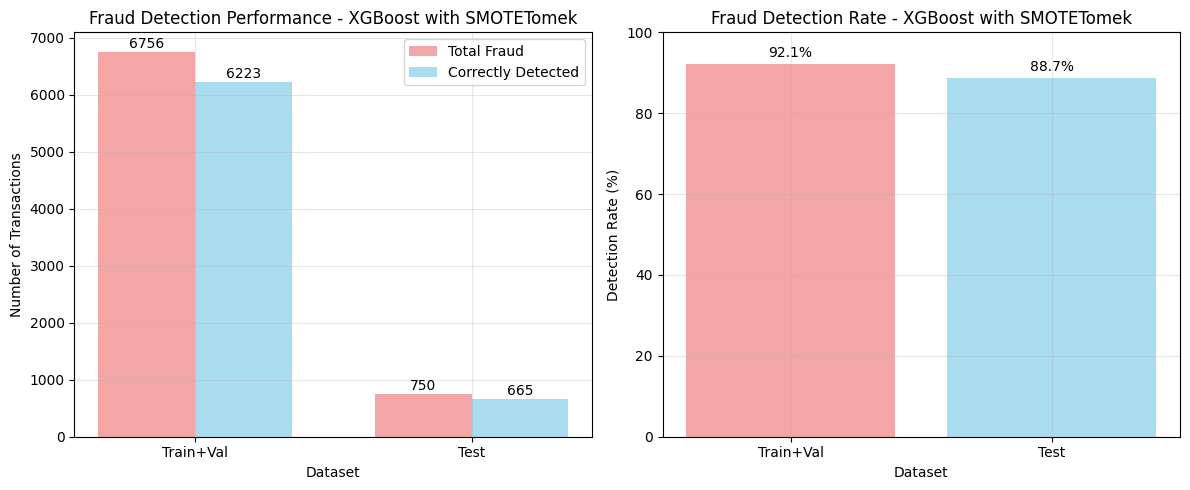


=== SMOTETomek Impact ===
• SMOTETomek resampling was applied during training to balance the dataset
• Test evaluation uses original imbalanced distribution for realistic assessment
• This approach should improve fraud detection recall while maintaining precision


In [69]:
# Fraud Detection Performance Analysis across Train+Val/Test sets
print("=== Fraud Detection Performance Analysis - XGBoost with SMOTETomek ===\n")

# Prepare datasets for analysis
datasets = {
    'Train+Val': (X_trainval, y_trainval),
    'Test': (X_test, y_test)
}

results = []

for dataset_name, (X_data, y_true) in datasets.items():
    # Get predictions
    y_pred = best_pipeline.predict(X_data)

    # Count fraud transactions
    total_fraud = (y_true == 1).sum()

    # Count correctly detected fraud (True Positives)
    correctly_detected = ((y_true == 1) & (y_pred == 1)).sum()

    # Count missed fraud (False Negatives)
    missed_fraud = ((y_true == 1) & (y_pred == 0)).sum()

    # Calculate detection rate
    detection_rate = correctly_detected / total_fraud * 100 if total_fraud > 0 else 0

    # Store results
    results.append({
        'Dataset': dataset_name,
        'Total Fraud': total_fraud,
        'Correctly Detected': correctly_detected,
        'Missed (False Negatives)': missed_fraud,
        'Detection Rate (%)': detection_rate
    })

    print(f"=== {dataset_name} Dataset ===")
    print(f"Total fraud transactions (is_fraud = 1): {total_fraud}")
    print(f"Correctly detected fraud: {correctly_detected}")
    print(f"Missed fraud (False Negatives): {missed_fraud}")
    print(f"Fraud detection rate: {detection_rate:.1f}%")
    print()

# Create summary DataFrame
df_fraud_performance = pd.DataFrame(results)
print("=== Summary Table ===")
display(df_fraud_performance)

# Visualize the results
plt.figure(figsize=(12, 5))

# Plot 1: Total vs Detected
plt.subplot(1, 2, 1)
x_pos = range(len(df_fraud_performance))
width = 0.35

plt.bar([x - width/2 for x in x_pos], df_fraud_performance['Total Fraud'],
        width, label='Total Fraud', color='lightcoral', alpha=0.7)
plt.bar([x + width/2 for x in x_pos], df_fraud_performance['Correctly Detected'],
        width, label='Correctly Detected', color='skyblue', alpha=0.7)

plt.xlabel('Dataset')
plt.ylabel('Number of Transactions')
plt.title('Fraud Detection Performance - XGBoost with SMOTETomek')
plt.xticks(x_pos, df_fraud_performance['Dataset'])
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (total, detected) in enumerate(zip(df_fraud_performance['Total Fraud'],
                                         df_fraud_performance['Correctly Detected'])):
    plt.text(i - width/2, total + 10, str(total), ha='center', va='bottom')
    plt.text(i + width/2, detected + 10, str(detected), ha='center', va='bottom')

# Plot 2: Detection Rate
plt.subplot(1, 2, 2)
bars = plt.bar(df_fraud_performance['Dataset'], df_fraud_performance['Detection Rate (%)'],
               color=['lightcoral', 'skyblue'], alpha=0.7)
plt.xlabel('Dataset')
plt.ylabel('Detection Rate (%)')
plt.title('Fraud Detection Rate - XGBoost with SMOTETomek')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, df_fraud_performance['Detection Rate (%)']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n=== SMOTETomek Impact ===")
print("• SMOTETomek resampling was applied during training to balance the dataset")
print("• Test evaluation uses original imbalanced distribution for realistic assessment")
print("• This approach should improve fraud detection recall while maintaining precision")